<h1><center> MODEL </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnice: <br>)
[comment]: <> (<code>conda install -c anaconda py-xgboost</code> <br>)
[comment]: <> (<code>conda install -c conda-forge imbalanced-learn</code>)

In [1]:
# packages
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from functions.model_helper import *

from yellowbrick.classifier import ClassBalance, ROCAUC
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


C:\Users\Matea\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
IPython_default = plt.rcParams.copy()

In [3]:
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

In [4]:
# load all train features, and data md5hash ids
md5hash_train = pd.read_csv("../../lfs/md5hash_train.csv")
features_train_with_filled_NaN_without_id = pd.read_csv("../../lfs/features_train_with_filled_NaN_without_id.csv")

# load all test features, and data md5hash ids
md5hash_test = pd.read_csv("../../lfs/md5hash_test.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("../../lfs/features_test_with_filled_NaN_without_id.csv")

In [5]:
# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

In [6]:
# load features from train and test dataset given using rfecv
selected_features_train = pd.read_csv("../dataset/selected features/rfc/selected_features_rfc_train_cv2_186.csv")
selected_features_test = pd.read_csv("../dataset/selected features/rfc/selected_features_rfc_test_cv2_186.csv")

# load table with feature names and their scores, sorted
feature_importances = pd.read_csv("../dataset/selected features/rfc/rfecv_cv2_186_feature_selected_with_names_and_importance_scores_sorted.csv")

In [7]:
feature_importances.head()

,feature_name,feature_importance
0,_allmul,0.025009
1,ent_q_diff_diffs_1_min,0.024926
2,ent_q_diff_diffs_1_median,0.021725
3,GetStringTypeA,0.021289
4,byte_1G_a2,0.019825


In [8]:
# setting random seed
seed = 47

In [9]:
# groups of features
one_gram_features = features_train_with_filled_NaN_without_id.iloc[:,:256]
metadata_bytes_features = features_train_with_filled_NaN_without_id.iloc[:,256:258]
entropy_features = features_train_with_filled_NaN_without_id.iloc[:,258:460]
image_features = features_train_with_filled_NaN_without_id.iloc[:,460:512]
string_length_features = features_train_with_filled_NaN_without_id.iloc[:,512:628]
metadata_asm_features = features_train_with_filled_NaN_without_id.iloc[:,628:630]
symbols_features = features_train_with_filled_NaN_without_id.iloc[:,630:637]
opcode_features = features_train_with_filled_NaN_without_id.iloc[:,637:730]
reg_features = features_train_with_filled_NaN_without_id.iloc[:,730:756]
section_features = features_train_with_filled_NaN_without_id.iloc[:,756:780]
dd_features = features_train_with_filled_NaN_without_id.iloc[:,780:804]
api_features = features_train_with_filled_NaN_without_id.iloc[:,804:1598]
key_features = features_train_with_filled_NaN_without_id.iloc[:,1598:1693]

<br>

## XGBClassifier

<span style="color:orange"><i>Objasniti ukratko zašto smo odabrali ovaj klasifikator. ~> copy-paste sa nekih od starih radova </i></span>

In [10]:
# define number of features to use
number_of_features_to_use = 50

In [11]:
# define data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

In [12]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

<span style="color:orange"><i>Ovdje sam ja samo pokušavala skužiti što se radi pa sam na basic modelu crtala i ispisivala sve što trebamo napraviti za najbolji model ili tako nesto.</i></span>

In [13]:
#eval_set = [(X_train, y_train), (X_test, y_test)]
#
#model = xgb.XGBClassifier(n_estimators=1000)
#model.fit(X_train, y_train, early_stopping_rounds=15, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

filename = 'model_1_xgb.sav'
basic_model = pickle.load(open(filename, 'rb'))
basic_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

<span style="color:orange"><i>Ispisivanje različitih scoreova najboljeg modela pronađenog prethodnom metodom.</i></span>

In [14]:
results = model_results(basic_model, X_test, y_test)
results

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.027673
1,accuracy_test,0.992947
2,F1_test,0.992787
3,precision_test,0.993003
4,auc_test_ovr,0.999767
5,auc_test_ovo,0.999382
6,r2_test,0.977485


<span style="color:orange"><i>Klasik, ovdje ćemo samo napisati očito, da nam je problem ta najmanja klasa malwarea i da smo zbog toga radili oversampling.</i></span>

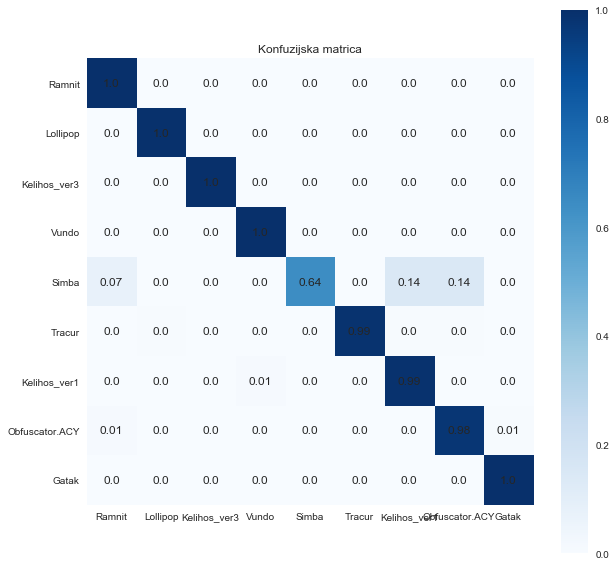

In [15]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, basic_model.predict(X_test))

<span style="color:orange"><i>Njihova željena <b>undercurve</b>. Oke vidim da je za Simbu najgora ofc.</i></span>

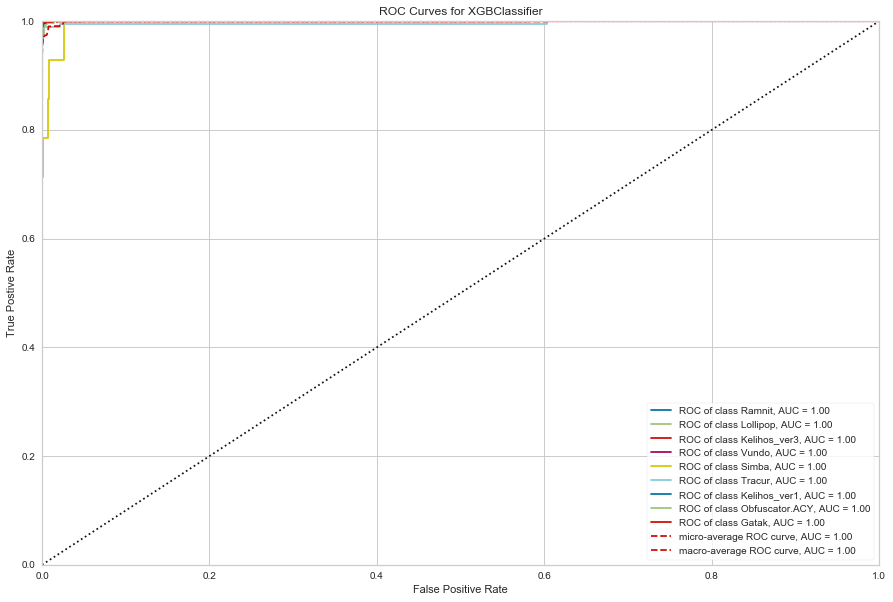

In [16]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#plt.style.use(plt.style.available[20])
plt.rcParams.update(IPython_default);

rocauc = ROCAUC(basic_model, size=(1080, 720), classes=list(malware_dict.values()), encoder=malware_dict )

rocauc.score(X_test, y_test)    
r = rocauc.poof()

<span style="color:orange"><i>Precision i recall. Iz ovog vidim da svaki put pogosi Simbu, ako je pogodi. Ali je ne pogodi svaki put jer je recall mali, odnosno ima dosta podataka koji su bili simba a nije ih prepoznao. Zato sam dolje ispisala iz dataframe sve retke u kojima je prediction za simbu bi iole veći od 0.1. Pa ću to možda malo proučiti. Isto sam otvorila excelicu pa idem po featurima da vidim ima li neki koji ističe simu jer ovdje nisam dobila neke informacije: https://www.hybrid-analysis.com/sample/f177c28aea4067de9056c8ccff9a7408561c945f96d55baf6b9d70543031f018?environmentId=100</i></span>

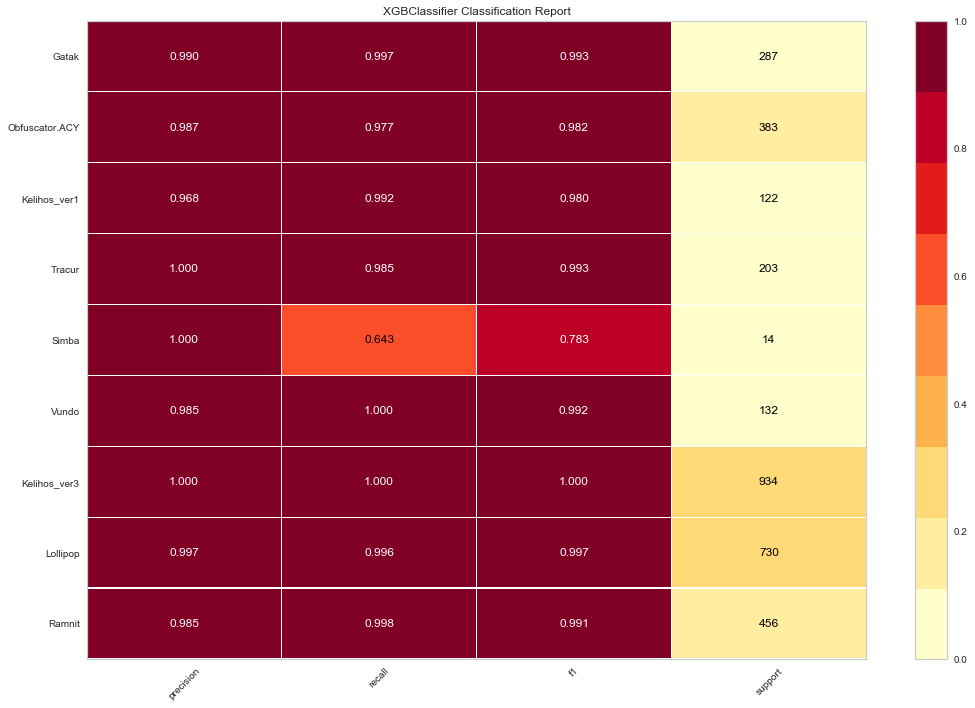

In [17]:
report = ClassificationReport(basic_model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

<span style="color:orange"><i>Ovo je super graf koji prikazuje po klasama malwarea koje je loše svrstao i gdje, vizualno. Živcira me što su iste boje nisam sigurna kako to riješiti.</i></span>

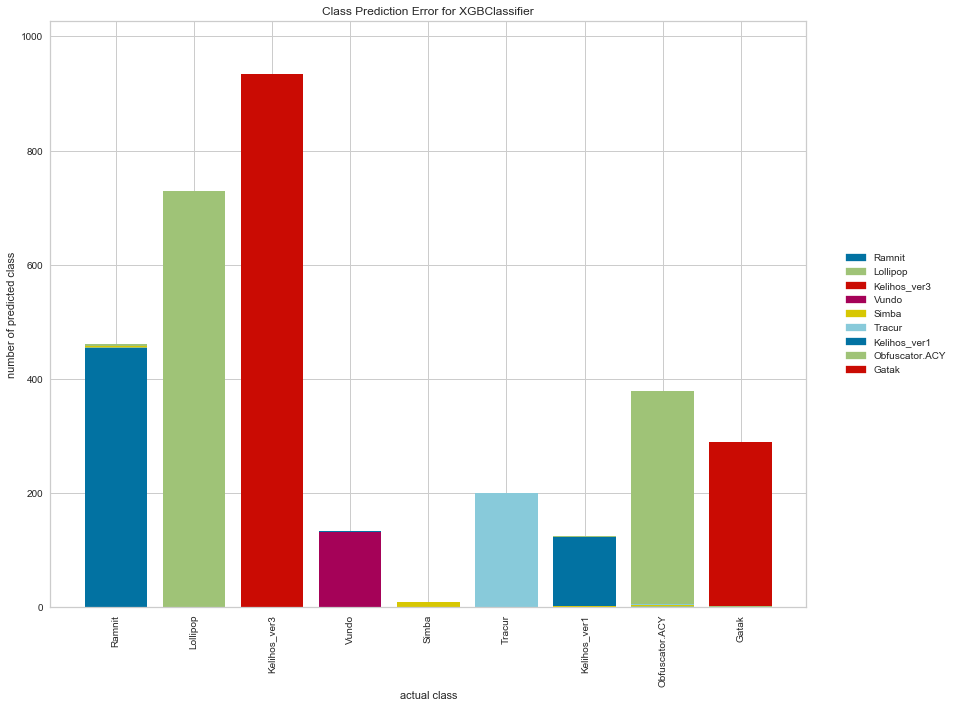

In [18]:
error = ClassPredictionError(basic_model, size=(1080, 720), classes=list(malware_dict.values()), encoder=malware_dict)

error.score(X_test, y_test)
e = error.poof()

<span style="color:orange"><i>Izvšavanje malo duže traje pa sam zakomentirala. Crtaju se learning curve (po accuracy scoreu), logloss krivulja i classification error krivulja po broju podataka u training setu.</i></span>

In [19]:
#plot_learning_curve( basic_model, X_train, y_train, X_test, y_test, 5, seed)

<span style="color:orange"><i>Važnost značajki. Kako ovo objasnit, ja ne znam. </i> </span>

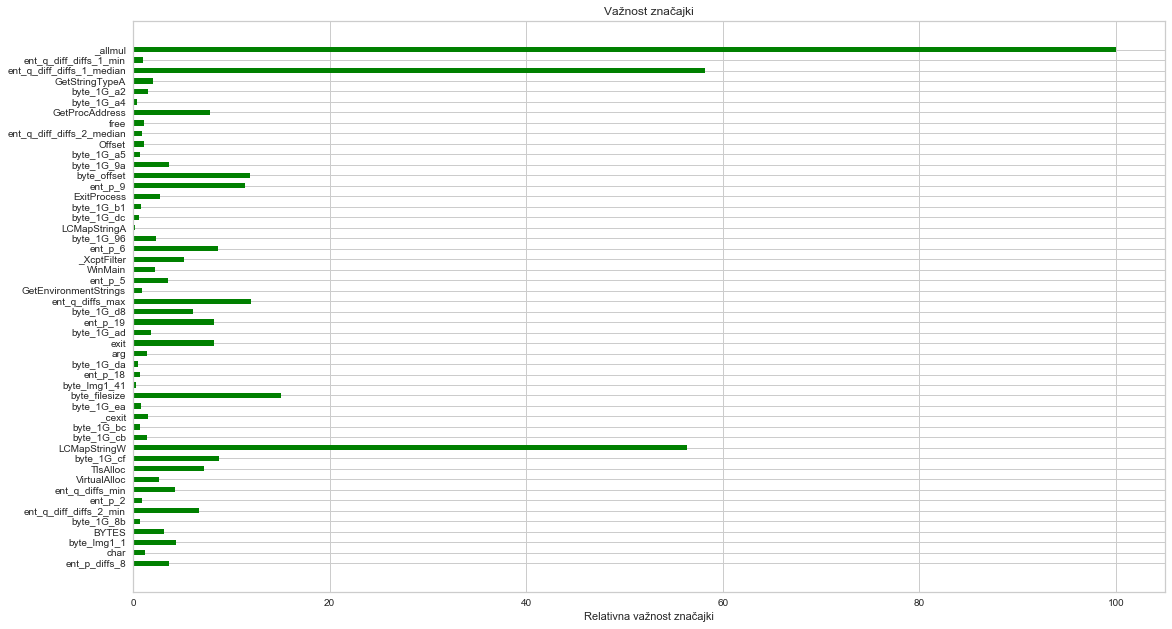

In [20]:
plot_feature_importance(basic_model, list(feature_importances["feature_name"].values[:number_of_features_to_use]))

<br><br>

### Potraga za parametrima

In [35]:
# define data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

In [31]:
model_XGB = XGBClassifier()

In [32]:
model_XGB.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [43]:
# define the parameter values that should be searched
n_estimators_range = [int(x) for x in np.linspace(start=70, stop=500, num=10)]

learning_range = list(range(1, 31))
learning_range = [x / 10 for x in learning_range]

depth_range = list(range(1, 101))

child_weight_range = list(range(1, 31))
child_weight_range = [x / 10 for x in child_weight_range]

max_delta_step_range = list(range(1, 10))

scale_pos_weight_range = list(range(1, 10))
scale_pos_weight_range.append(0.5)
scale_pos_weight_range.append(0.6)
scale_pos_weight_range.append(0.7)
scale_pos_weight_range.append(0.8)
scale_pos_weight_range.append(0.9)

base_score_range = list(range(5, 10))
base_score_range = [x / 10 for x in base_score_range]

subsample_range = list(range(1, 10))
subsample_range = [x / 10 for x in subsample_range]

colsample_bytree_range = list(range(1, 10))
colsample_bytree_range = [x / 10 for x in colsample_bytree_range]

colsample_bylevel_range = list(range(1, 10))
colsample_bylevel_range = [x / 10 for x in colsample_bylevel_range]

gamma = [ 0, 0.001, 0.005, 0.01, 0.1, 0.5] #default 0
reg_alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] #default 0
reg_lambda = [0, 0.01, 0.1, 0.5, 0.75, 1] #default 1

#max depth of tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]


In [44]:
random_grid = {
               'n_estimators': n_estimators_range,
               'learning_rate': learning_range,
               'max_features': ['auto','log2'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'gamma' : gamma,
               'reg_alpha':reg_alpha,
               'reg_lambda':reg_lambda
              }

In [ ]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
rand_XGB = RandomizedSearchCV(model_XGB, 
                              param_distributions = random_grid, 
                              cv=StratifiedKFold(n_splits=10), 
                              scoring='neg_log_loss', 
                              n_iter=20, 
                              random_state=47, 
                              return_train_score=False, 
                              verbose=True)

rand_XGB.fit(data, labels)
df_l = pd.DataFrame(rand_XGB.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

#Save model
filename = 'rand_XGB_cv10_try1_ll.sav'
pickle.dump(rand_XGB, open(filename, 'wb'))

filename = 'model_XGB_cv10_try1_ll.sav'
pickle.dump(model_XGB, open(filename, 'wb'))

best_Rand_cv10 = rand_XGB.best_estimator_
filename = 'rand_XGB.best_estimator_cv10_try1_actual_model_ll.sav'
pickle.dump(model_XGB, open(filename, 'wb'))

# plot of randomized search results
rand_XGB_mean_scores = rand_XGB.cv_results_['mean_test_score']
plt.plot(list(range(1, 21)), rand_XGB_mean_scores)
plt.xlabel('k-ti Model Randomized Search CV treniranja (XGB)')
plt.ylabel('Cross-Validated Accuracy')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
df_l

In [ ]:
# examine the best model
print(rand_XGB.best_score_)
print(rand_XGB.best_params_)

In [ ]:
m_XGB = XGBClassifier(max_depth = rand_XGB.best_params_['max_depth'],
                      learning_rate = rand_XGB.best_params_['learning_rate'],
                      base_score = rand_XGB.best_params_['base_score'])

filename = 'best_m_XGB_cv10_try1_ll.sav'
pickle.dump(m_XGB, open(filename, 'wb'))

<br>

### a sad, accuracy

In [ ]:
model_XGBa = XGBClassifier()
# define data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

# we use the RandomizedSearchCV to find the best parameters for our XGB model
rand_XGBa = RandomizedSearchCV(model_XGBa, 
                              param_distributions = random_grid, 
                              cv=StratifiedKFold(n_splits=10), 
                              scoring='accuracy', 
                              n_iter=20, 
                              random_state=40, 
                              return_train_score=False, 
                              verbose=True)

rand_XGBa.fit(data, labels)
df_a = pd.DataFrame(rand_XGBa.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

#Save model
filename = 'rand_XGBa_cv10_try1_accuracy.sav'
pickle.dump(rand_XGBa, open(filename, 'wb'))

filename = 'model_XGBa_cv10_try1_accuracy.sav'
pickle.dump(model_XGBa, open(filename, 'wb'))

best_Rand_cv10a = rand_XGB.best_estimator_
filename = 'rand_XGBa.best_estimator_cv10_try1_actual_model_accuracy.sav'
pickle.dump(best_Rand_cv10a, open(filename, 'wb'))

# plot of randomized search results
rand_XGB_mean_scores_A = rand_XGBa.cv_results_['mean_test_score']
plt.plot(list(range(1, 21)), rand_XGB_mean_scores_A)
plt.xlabel('k-ti Model Randomized Search CV treniranja (XGB)')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
df_a

In [ ]:
# examine the best model
print(rand_XGBa.best_score_)
print(rand_XGBa.best_params_)

In [ ]:
m_XGBa = XGBClassifier(max_depth = rand_XGBa.best_params_['max_depth'],
                      learning_rate = rand_XGBa.best_params_['learning_rate'],
                      base_score = rand_XGBa.best_params_['base_score'])

filename = 'best_m_XGBa_cv10_try1_accuracy.sav'
pickle.dump(m_XGBa, open(filename, 'wb'))

<br><br>

Sada ćemo kreirati datoteku s kojom ćemo provjeriti ( _logloss_ ) točnost _test_ skupa na [Kaggle-u](https://www.kaggle.com/c/malware-classification/overview).

In [21]:
submission = make_submisson_file(md5hash_test, basic_model.predict_proba(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))

In [22]:
submission.head()

,Id,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9
0,ITSUPtCmh7WdJcsYDwQ5,0.000068,0.000053,0.000279,0.000161,0.910417,0.052540,0.000831,0.033285,0.002367
1,Ig2DB5tSiEy1cJvV0zdw,0.000009,0.000052,0.000039,0.000023,0.992426,0.002440,0.000154,0.004760,0.000096
2,Jmo6eIhLZ4t9r8QsxEg5,0.000006,0.000009,0.000022,0.000028,0.996575,0.000242,0.000067,0.003034,0.000017
3,JtPFl4ewgdD78OzCMa3o,0.000440,0.000153,0.000601,0.000442,0.013279,0.035369,0.000428,0.947296,0.001993
4,K3ZtByPHGSFYNljDUEXp,0.000011,0.000005,0.999451,0.000020,0.000034,0.000053,0.000058,0.000317,0.000051


In [23]:
submission[submission["Prediction5"]> 0.1]

,Id,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9
0,ITSUPtCmh7WdJcsYDwQ5,0.000068,0.000053,0.000279,0.000161,0.910417,0.052540,0.000831,0.033285,0.002367
1,Ig2DB5tSiEy1cJvV0zdw,0.000009,0.000052,0.000039,0.000023,0.992426,0.002440,0.000154,0.004760,0.000096
2,Jmo6eIhLZ4t9r8QsxEg5,0.000006,0.000009,0.000022,0.000028,0.996575,0.000242,0.000067,0.003034,0.000017
28,KGA8EhzSPqxyN9wCmeiV,0.000004,0.000003,0.000010,0.000008,0.998455,0.000210,0.000008,0.001289,0.000012
105,KceFACkhxOnPlMqSm1u5,0.000372,0.001086,0.000913,0.000773,0.737044,0.114955,0.000729,0.141463,0.002666
300,LI2xnt3GVFzcdSZk8WUA,0.000014,0.000030,0.000048,0.000022,0.990832,0.006217,0.000034,0.002695,0.000109
384,LbBV3xmqGiuRghISrkXf,0.000547,0.000023,0.000092,0.000102,0.103244,0.894776,0.000066,0.000838,0.000313
451,LniCWfMIvXj34dHVycSK,0.001834,0.003628,0.011889,0.003867,0.852570,0.004204,0.057731,0.053470,0.010807
659,MLz1ycxqabVk4m07fJTN,0.001183,0.000016,0.000085,0.000017,0.997000,0.001069,0.000109,0.000361,0.000159
946,N9v3iUhagAZf2S8kLqwK,0.002429,0.014947,0.010360,0.003851,0.628935,0.028074,0.015446,0.270762,0.025196


In [24]:
classes = np.asarray(basic_model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))

Broj malwarea po klasama:
dict_values([1463, 1823, 2951, 546, 40, 536, 410, 1864, 1240])
Postotci malwarea po klasama:
[13.455348109997242, 16.766301848615836, 27.140623562954108, 5.021613170238204, 0.3678837487353996, 4.929642233054355, 3.7708084245378464, 17.143382691069622, 11.404396210797389]


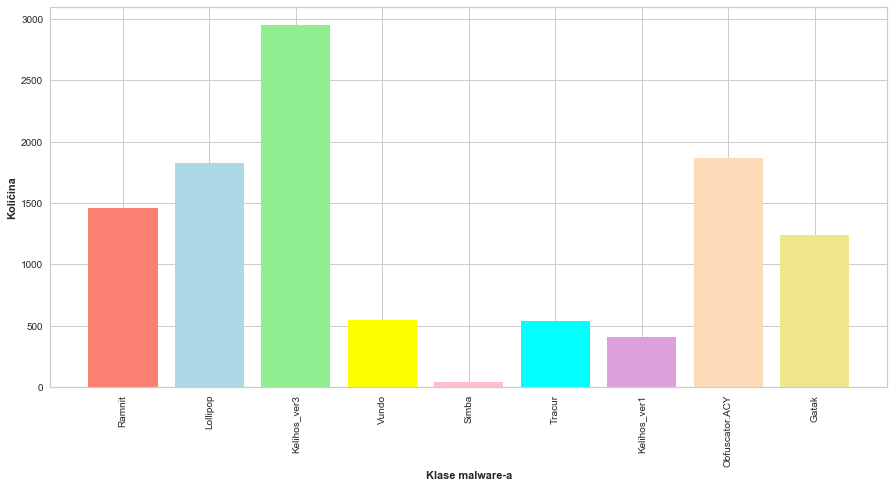

In [25]:
draw_malware_distribution_over_classes(classes)

<span style="color:orange"><i>U odnosu na training set možemo očekivati istu distribuciju podataka u test setu. Lolipopa ima dosta manje, sa 22,79% pao je na 16,76%! Ostali su više manje okej. Problem još mogu biti  Obfuscator koji je prije bio 11.29% a sada je 17.14%!!! Također, Gatak je prije bio 9.31% a sad je 11.4%.</i></span>

<br><br>

***

## RUSKI

<span style="color:orange"><i>Ovo sam vam napisala na slack.</i></span>

In [26]:
ruski_submission = pd.read_csv('ruski.238671')
ruski_submission.head()

,Id,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9
0,ITSUPtCmh7WdJcsYDwQ5,0.000038,0.000061,0.000078,0.000056,0.999401,0.000114,0.000100,0.000106,0.000046
1,Ig2DB5tSiEy1cJvV0zdw,0.000044,0.000070,0.000080,0.000058,0.999420,0.000078,0.000091,0.000093,0.000066
2,Jmo6eIhLZ4t9r8QsxEg5,0.000127,0.000244,0.000260,0.000252,0.992160,0.000948,0.000317,0.005263,0.000430
3,JtPFl4ewgdD78OzCMa3o,0.001735,0.002847,0.003453,0.005852,0.883732,0.019086,0.017733,0.032387,0.033175
4,K3ZtByPHGSFYNljDUEXp,0.000002,0.000006,0.999959,0.000005,0.000006,0.000006,0.000006,0.000003,0.000008


In [28]:
ruske_klape = []
for i in range(10873):
    ruske_klape.append(np.argmax(ruski_submission.iloc[i,1:].values) + 1)
    
ruski_klase = pd.concat([ ruski_submission['Id'], pd.DataFrame(ruske_klape)], axis=1, sort=False)

In [29]:
ruski_klase.columns = ["Id", "Class"]
#ruski_klase.to_csv("ruske_klase.csv")
ruski_klase.head()

,Id,Class
0,ITSUPtCmh7WdJcsYDwQ5,5
1,Ig2DB5tSiEy1cJvV0zdw,5
2,Jmo6eIhLZ4t9r8QsxEg5,5
3,JtPFl4ewgdD78OzCMa3o,5
4,K3ZtByPHGSFYNljDUEXp,3


Broj malwarea po klasama:
dict_values([1549, 2478, 2945, 476, 43, 750, 398, 1224, 1010])
Postotci malwarea po klasama:
[14.24629816977835, 22.790398234158005, 27.085441000643794, 4.377816609951255, 0.3954750298905546, 6.897820288788743, 3.6604432999172265, 11.257242711303228, 9.28906465556884]


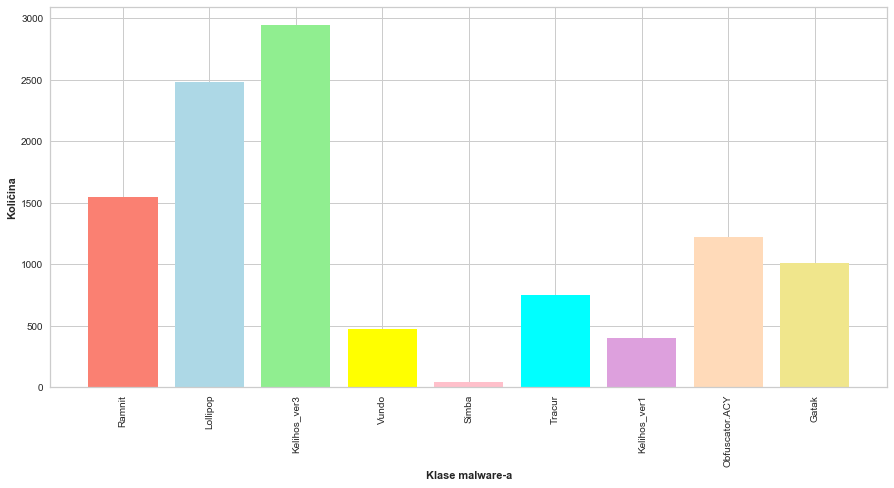

In [30]:
draw_malware_distribution_over_classes(ruski_klase["Class"])

<br>

***